In [3]:
import re
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import joblib


#  Load Dataset

In [7]:
DATA_PATH = "/kaggle/input/recruitment-scam/DataSet.csv"   # change if needed
df = pd.read_csv(DATA_PATH)

if "fraudulent" not in df.columns:
    raise ValueError("Expected label column 'fraudulent' not found in dataset.")

print("Shape:", df.shape)
print("Label distribution:\n", df["fraudulent"].value_counts(dropna=False))

Shape: (17880, 18)
Label distribution:
 fraudulent
f    17014
t      866
Name: count, dtype: int64


# Text Cleaning Helpers

In [9]:
HTML_TAG_RE = re.compile(r"<[^>]+>")
URL_RE = re.compile(r"http\S+|www\.\S+")
MULTISPACE_RE = re.compile(r"\s+")

def clean_text(text: str) -> str:
    """Light cleaning suitable for TF-IDF text classification."""
    if pd.isna(text):
        return ""
    text = str(text)

    # remove html
    text = re.sub(HTML_TAG_RE, " ", text)

    # remove urls
    text = re.sub(URL_RE, " ", text)

    # lowercase
    text = text.lower()

    # remove weird control characters
    text = text.replace("\r", " ").replace("\n", " ").replace("\t", " ")

    # collapse spaces
    text = re.sub(MULTISPACE_RE, " ", text).strip()
    return text

# Combine Useful Columns

In [11]:
text_cols = [
    "title",
    "location",
    "department",
    "company_profile",
    "description",
    "requirements",
    "benefits",
    "employment_type",
    "required_experience",
    "required_education",
    "industry",
    "function",
]

# Keep only columns that exist (safe)
text_cols = [c for c in text_cols if c in df.columns]

def make_combined_text(row) -> str:
    parts = []
    for c in text_cols:
        parts.append(clean_text(row.get(c, "")))
    return " ".join([p for p in parts if p])

df["combined_text"] = df.apply(make_combined_text, axis=1)

# Drop empty rows if any
df = df[df["combined_text"].str.len() > 0].copy()

X = df["combined_text"]
df["fraudulent"] = df["fraudulent"].map({"t": 1, "f": 0})
y = df["fraudulent"]

# Train/Test Split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("\nTrain size:", len(X_train), "Test size:", len(X_test))


Train size: 14304 Test size: 3576


# TF-IDF + LinearSVC Model

In [16]:
model = Pipeline([
    ("tfidf", TfidfVectorizer(
        max_features=150000,      
        ngram_range=(1, 2),       # unigrams + bigrams
        min_df=2,                 # ignore very rare terms
        stop_words="english"      # ok even if dataset has mostly English
    )),
    ("clf", LinearSVC(class_weight="balanced", random_state=42))
])

# Train

In [17]:
model.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=150000, min_df=2,
                                 ngram_range=(1, 2), stop_words='english')),
                ('clf', LinearSVC(class_weight='balanced', random_state=42))])

# Evaluate

In [18]:
y_pred = model.predict(X_test)

print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=4))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.9921700223713646

Classification Report:
               precision    recall  f1-score   support

           0     0.9936    0.9982    0.9959      3403
           1     0.9618    0.8728    0.9152       173

    accuracy                         0.9922      3576
   macro avg     0.9777    0.9355    0.9555      3576
weighted avg     0.9920    0.9922    0.9920      3576


Confusion Matrix:
 [[3397    6]
 [  22  151]]


# Predict on New Samples

In [19]:
def predict_fake_job(title, description, requirements=""):
    sample = clean_text(title) + " " + clean_text(description) + " " + clean_text(requirements)
    pred = model.predict([sample])[0]
    return "FAKE (1)" if pred == 1 else "REAL (0)"

# Example:
print("\nExample Prediction:",
      predict_fake_job(
          "Work from home and earn $5000/week!!!",
          "No experience needed. Click link now.",
          "Must have internet connection"
      ))


Example Prediction: FAKE (1)


# Graphs

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## Confusion Matrix Heatmap

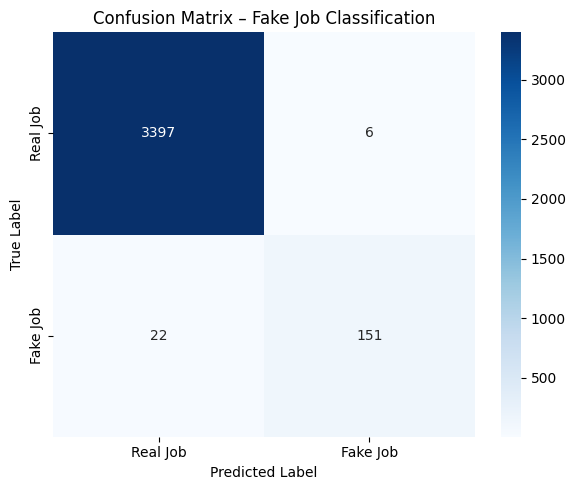

In [22]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Real Job", "Fake Job"],
    yticklabels=["Real Job", "Fake Job"]
)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix – Fake Job Classification")
plt.tight_layout()
plt.show()


## Class Distribution (Dataset Imbalance)

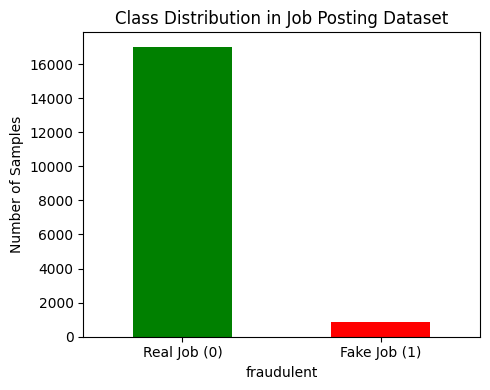

In [23]:
plt.figure(figsize=(5, 4))
df["fraudulent"].value_counts().plot(
    kind="bar",
    color=["green", "red"]
)

plt.xticks([0, 1], ["Real Job (0)", "Fake Job (1)"], rotation=0)
plt.ylabel("Number of Samples")
plt.title("Class Distribution in Job Posting Dataset")
plt.tight_layout()
plt.show()

## Precision, Recall & F1-Score Bar Chart

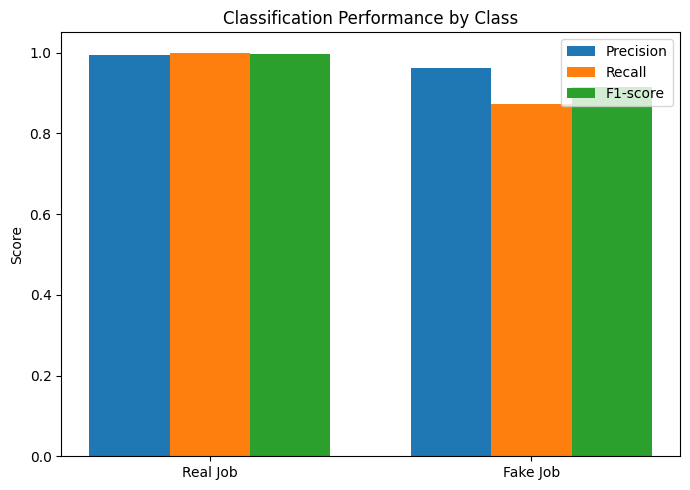

In [24]:
from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred, output_dict=True)

labels = ["Real Job", "Fake Job"]
precision = [report["0"]["precision"], report["1"]["precision"]]
recall = [report["0"]["recall"], report["1"]["recall"]]
f1 = [report["0"]["f1-score"], report["1"]["f1-score"]]

x = np.arange(len(labels))
width = 0.25

plt.figure(figsize=(7, 5))
plt.bar(x - width, precision, width, label="Precision")
plt.bar(x, recall, width, label="Recall")
plt.bar(x + width, f1, width, label="F1-score")

plt.xticks(x, labels)
plt.ylim(0, 1.05)
plt.ylabel("Score")
plt.title("Classification Performance by Class")
plt.legend()
plt.tight_layout()
plt.show()


## Top TF-IDF Features

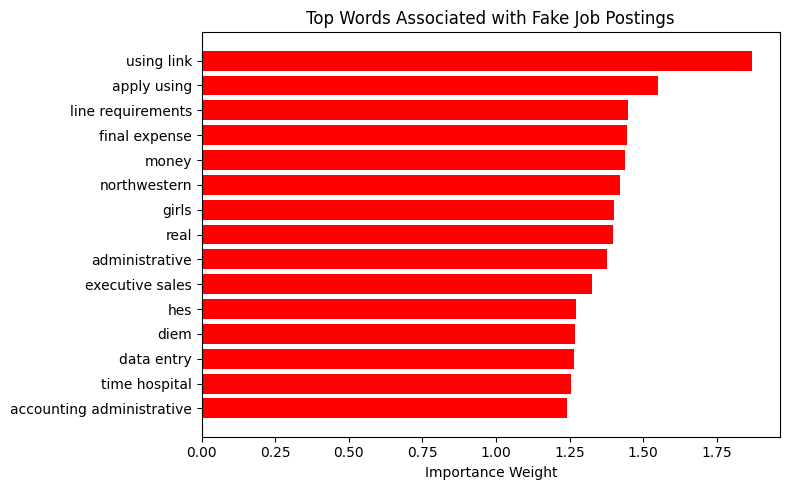

In [25]:
tfidf = model.named_steps["tfidf"]
clf = model.named_steps["clf"]

feature_names = np.array(tfidf.get_feature_names_out())
coefficients = clf.coef_[0]

# Top positive → Fake Jobs
top_fake_idx = np.argsort(coefficients)[-15:]
top_fake_words = feature_names[top_fake_idx]
top_fake_scores = coefficients[top_fake_idx]

plt.figure(figsize=(8, 5))
plt.barh(top_fake_words, top_fake_scores, color="red")
plt.title("Top Words Associated with Fake Job Postings")
plt.xlabel("Importance Weight")
plt.tight_layout()
plt.show()
